In [16]:
# Code follow along from https://www.kaggle.com/code/tientd95/advanced-pyspark-for-exploratory-data-analysis

In [17]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

In [18]:
import pyspark
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").appName("EDA").getOrCreate()

In [19]:
spark

In [7]:

# mode = DROPMALFORMED ignores whole corrupted records
df = spark.read.json("./endomondoHR.json", mode='DROPMALFORMED')

In [20]:
df.rdd.getNumPartitions()

49

## Overview of Dataset

### Schema

In [21]:
df.printSchema()

root
 |-- altitude: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- gender: string (nullable = true)
 |-- heart_rate: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- id: long (nullable = true)
 |-- latitude: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- longitude: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- speed: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- sport: string (nullable = true)
 |-- timestamp: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- url: string (nullable = true)
 |-- userId: long (nullable = true)



In [22]:
pd.DataFrame(df.dtypes, columns=["Column Name", 'Data Type'])

,Column Name,Data Type
0,altitude,array<double>
1,gender,string
2,heart_rate,array<bigint>
3,id,bigint
4,latitude,array<double>
5,longitude,array<double>
6,speed,array<double>
7,sport,string
8,timestamp,array<bigint>
9,url,string


### Statistical Information

In [23]:
df.describe().toPandas()

,summary,gender,id,sport,url,userId
0,count,253020,253020,253020,253020,253020
1,mean,None,3.566244412926132E8,None,None,4619648.939783417
2,stddev,None,1.574845634895318E8,None,None,3932877.7296880507
3,min,female,99296,aerobics,https://www.endomondo.com/users/10014612/worko...,69
4,max,unknown,674008008,yoga,https://www.endomondo.com/users/9991401/workou...,15481421


In [24]:
df.limit(2).toPandas()

,altitude,gender,heart_rate,id,latitude,longitude,speed,sport,timestamp,url,userId
0,"[41.6, 40.6, 40.6, 38.4, 37.0, 34.0, 34.0, 34....",male,"[100, 111, 120, 119, 120, 116, 125, 128, 131, ...",396826535,"[60.173348765820265, 60.173239801079035, 60.17...","[24.64977040886879, 24.65014273300767, 24.6509...","[6.8652, 16.4736, 19.1988, 20.4804, 31.3956, 3...",bike,"[1408898746, 1408898754, 1408898765, 140889877...",https://www.endomondo.com/users/10921915/worko...,10921915
1,"[38.4, 39.0, 39.0, 38.2, 36.8, 36.8, 36.8, 35....",male,"[100, 105, 111, 110, 108, 115, 126, 130, 132, ...",392337038,"[60.173247596248984, 60.17320962622762, 60.172...","[24.649855233728886, 24.65015547350049, 24.650...","[9.0792, 13.284, 15.9336, 10.9476, 16.1676, 30...",bike,"[1408221682, 1408221687, 1408221699, 140822170...",https://www.endomondo.com/users/10921915/worko...,10921915


In [25]:
print(f"There are {df.count()} rows.")

There are 253020 rows.


## Missing Values and Abnormal Zeroes

In [26]:
from pyspark.sql.functions import col, array_contains

string_columns = ['gender', 'sport', 'url']
numeric_columns = ['id','userId']
array_columns = ['altitude', 'heart_rate', 'latitude', 'longitude', 'speed', 'timestamp']

missing_values = {}

for index, column in enumerate(df.columns):

    # Check for columns with None and Null values
    if column in string_columns:
        # Get missing count per col
        missing_count = df.filter(col(column).eqNullSafe(None) | col(column).isNull()).count() # eqNullSafe -> Equality test that is safe for null values

       
    
    # Check for columns with zeroes, None, NaN
    if column in numeric_columns:
        # Miss Count
        missing_count = df.where(col(column).isin([0, None, np.nan])).count()

    # Check for columns with zeroes and NaN
    if column in array_columns:
        # Miss Count
        missing_count = df.filter(array_contains(df[column], 0) | array_contains(df[column], np.nan)).count()

    # Add to dict
    missing_values.update({column: missing_count})

missing_df = pd.DataFrame.from_dict([missing_values])
missing_df

,altitude,gender,heart_rate,id,latitude,longitude,speed,sport,timestamp,url,userId
0,40848,0,1280,0,113,113,7741,0,0,0,0


In [29]:
df.limit(1).toPandas()

,altitude,gender,heart_rate,id,latitude,longitude,speed,sport,timestamp,url,userId
0,"[41.6, 40.6, 40.6, 38.4, 37.0, 34.0, 34.0, 34....",male,"[100, 111, 120, 119, 120, 116, 125, 128, 131, ...",396826535,"[60.173348765820265, 60.173239801079035, 60.17...","[24.64977040886879, 24.65014273300767, 24.6509...","[6.8652, 16.4736, 19.1988, 20.4804, 31.3956, 3...",bike,"[1408898746, 1408898754, 1408898765, 140889877...",https://www.endomondo.com/users/10921915/worko...,10921915


In [32]:
from pyspark.sql.functions import size

# Create a new column to count the number of timestamps recorded per row/workout
df = df.withColumn('PerWorkoutRecordCount', size(col('timestamp')))
df.limit(1).toPandas()


,altitude,gender,heart_rate,id,latitude,longitude,speed,sport,timestamp,url,userId,PerWorkoutRecordCount
0,"[41.6, 40.6, 40.6, 38.4, 37.0, 34.0, 34.0, 34....",male,"[100, 111, 120, 119, 120, 116, 125, 128, 131, ...",396826535,"[60.173348765820265, 60.173239801079035, 60.17...","[24.64977040886879, 24.65014273300767, 24.6509...","[6.8652, 16.4736, 19.1988, 20.4804, 31.3956, 3...",bike,"[1408898746, 1408898754, 1408898765, 140889877...",https://www.endomondo.com/users/10921915/worko...,10921915,500


In [38]:
df.groupBy('gender').count().toPandas()

,gender,count
0,unknown,1942
1,female,15959
2,male,235119


In [39]:

import pyspark.sql
from pyspark.sql import functions
def user_activity_workout_summarize(df: pyspark.sql.DataFrame):

    # Count of unique values
    user_count = format(df.select('userId').distinct().count(), ',d')
    workout_count = format(df.select('id').distinct().count(), ',d')
    activity_count = str(df.select('sport').distinct().count())

    # Sum of all PerWorkoutRecordCount
    sum_temp = df.agg(functions.sum('PerWorkoutRecordCount')).toPandas()
    total_records_count = format(sum_temp['sum(PerWorkoutRecordCount)'][0], ',d')

    columns = ['Users count', 'Activity types count', 'Workouts count', 'Total records count']

    data = [[user_count], [activity_count], [workout_count], [total_records_count]]

    # Data to dict then dataframe
    sum_dict = {column: data[i] for i, column in enumerate(columns)}
    sum_df = pd.DataFrame.from_dict(sum_dict)[columns]

    # Get count of unique users per gender
    gender_user_count = df.select('gender', 'userId').distinct().groupBy('gender').count().toPandas()

    # Count of unique genders
    gender_activities_count = df.groupBy('gender').count().toPandas()

    gender_user_activity_count = gender_user_count.join(
        gender_activities_count.set_index('gender'),
        on ='gender',
        how = 'inner',
        lsuffix='_gu'
    )   
    gender_user_activity_count.columns = ['Gender', '# of users', 'Activities (workouts) count']

    return sum_df, gender_user_activity_count

sum_dfs = user_activity_workout_summarize(df)

sum_dfs



(  Users count Activity types count Workouts count Total records count
 0       1,104                   49        253,020         111,541,956,
     Gender  # of users  Activities (workouts) count
 0  unknown          15                         1942
 1   female         110                        15959
 2     male         979                       235119)

In [40]:
sum_dfs[0]

,Users count,Activity types count,Workouts count,Total records count
0,"1,104",49,"253,020","111,541,956"


In [41]:
sum_dfs[1]

,Gender,# of users,Activities (workouts) count
0,unknown,15,1942
1,female,110,15959
2,male,979,235119


In [44]:
# Data about workouts having less than 50 records
removed_df = df.select('PerWorkoutRecordCount').where(df.PerWorkoutRecordCount < 50).toPandas().describe().astype(int)

removed_df.rename(columns = {'PerWorkoutRecordCount': 'PerWorkoutRecordCount < 50'}, inplace = True)
removed_df.T

,count,mean,std,min,25%,50%,75%,max
PerWorkoutRecordCount < 50,5541,23,14,1,11,22,36,49


In [59]:
# Getting workout sport done by most user
ranked_sport_users_df = df.select(df.sport, df.userId) \
    .distinct() \
    .groupBy(df.sport) \
    .count() \
    .orderBy('count', ascending=False)

# Top 5 workout types
highest_sport_users_df = ranked_sport_users_df.limit(5).toPandas()
# Rename column name : 'count' --> Users count
highest_sport_users_df.rename(columns = {'count':'Users count'}, inplace = True)

highest_sport_users_df



,sport,Users count
0,run,865
1,bike,794
2,mountain bike,336
3,bike (transport),252
4,walk,209


In [56]:
total_sports_users = ranked_sport_users_df.groupBy().sum().collect()

In [58]:
total_sports_users[0][0]

3442

## Exploratory Data Analysis

In [75]:
highest_sport_users_df_renamed = highest_sport_users_df

# Get percentage of top 5 sports
highest_sport_users_df_renamed['percentage'] = highest_sport_users_df['Users count'] / total_sports_users[0][0] * 100
highest_sport_users_df_renamed['percentage']

0    25.130738
1    23.067984
2     9.761766
3     7.321325
4     6.072051
Name: percentage, dtype: float64

In [76]:
# Assign rest of the users as 'other'

others = {
    'sport': 'others',
    'Users count': total_sports_users[0][0] - sum(highest_sport_users_df_renamed['Users count']),
    'percentage': 100 - sum(highest_sport_users_df_renamed['percentage'])
}
others

{'sport': 'others', 'Users count': 986, 'percentage': 28.64613596746078}

In [77]:
# Add others to the sports percentage df

highest_sport_users_df_renamed = highest_sport_users_df_renamed.append(
    others, ignore_index=True
)

highest_sport_users_df_renamed

/tmp/ipykernel_3613/3746181748.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  highest_sport_users_df_renamed = highest_sport_users_df_renamed.append(


,sport,Users count,percentage
0,run,865,25.130738
1,bike,794,23.067984
2,mountain bike,336,9.761766
3,bike (transport),252,7.321325
4,walk,209,6.072051
5,others,986,28.646136


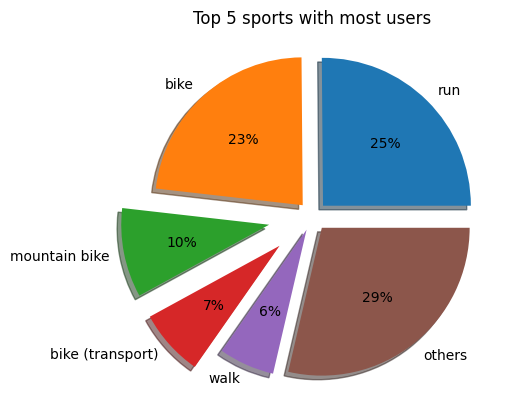

In [86]:
# Plotting
import matplotlib.pyplot as plt

plt.title("Top 5 sports with most users")
plt.pie(highest_sport_users_df_renamed['percentage'], labels =  highest_sport_users_df_renamed['sport'], autopct='%.0f%%', shadow = True, explode = (0.1, .1, .3, .3, .1, .1));